In [5]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import eigh

## The code below optimizes the two-body matrix elements by fitting three parameters, $v_1$, $v_2$, and $v_3$.

In [13]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


#define single particle states in harmonic oscillator basis up to 16O
A = 16
n = np.zeros(A)
l = np.array([0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1])
j = np.array([0.5,0.5,0.5,0.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,0.5,0.5,0.5,0.5])
mj = np.array([0.5,-0.5,0.5,-0.5,1.5,0.5,-0.5,-1.5,1.5,0.5,-0.5,-1.5,0.5,-0.5,0.5,-0.5])
t3 = np.array([0.5,0.5,-0.5,-0.5,0.5,0.5,-0.5,-0.5,0.5,0.5,-0.5,-0.5,0.5,0.5,-0.5,-0.5])

# single-particle energies using HO
def HO_energies(n,l):
    hbar_omega = 41.0/(A**(1/3))
    return hbar_omega*(2*n + l + 1.5)



# Experimental binding energies in MeV 
BE_4He_exp  = 28.2956624   
BE_6He_exp  = 29.2711194   
BE_12C_exp  = 92.1617352 
BE_14C_exp  = 105.2844772
BE_16O_exp  = 127.6193152  


# Initialization of me2b values based on experimental binding energies


# 0s1/2–0s1/2 
v1 = - BE_4He_exp /6

#0p3/2–0p3/2
v2 = - (BE_6He_exp - BE_4He_exp)

#0p1/2–0p1/2
v3 = - (BE_14C_exp - BE_12C_exp)

print("v1, v2, v3 =", v1, v2, v3)



shell_type = np.zeros(A, dtype=int)
for a in range(A):
    if l[a] == 0:
        shell_type[a] = 0
    elif l[a] == 1 and j[a] == 1.5:
        shell_type[a] = 1     
    elif l[a] == 1 and j[a] == 0.5:
        shell_type[a] = 2     



rng = np.random.default_rng(123)
VJ0_rand = np.zeros((3, 3))

for i in range(3):
    for jj in range(i + 1, 3):
        val = rng.normal(0.0, 0.1)
        VJ0_rand[i, jj] = val
        VJ0_rand[jj, i] = val



def get_Vme2b(v1, v2, v3):
    
    VJ0 = np.zeros((3, 3))

    VJ0[0, 0] = v1
    VJ0[1, 1] = v2
    VJ0[2, 2] = v3
    '''
    VJ0[3, 3] = v2
    VJ0[4, 4] = v2
    VJ0[5, 5] = v2
    VJ0[6, 6] = v3
    VJ0[7, 7] = v3
    VJ0[8, 8] = v3
    '''

    VJ0 += VJ0_rand  


    V_raw = np.zeros((A, A, A, A))

    def orbit_index(a):
        return shell_type[a]  

    for a in range(A):
        alpha = orbit_index(a)
        j_a = j[a]
        m_a = mj[a]
        for c in range(A):
            if orbit_index(c) != alpha:
                continue
            if mj[c] != -m_a:
                continue

            for b in range(A):
                beta = orbit_index(b)
                j_b = j[b]
                m_b = mj[b]
                for d in range(A):
                    if orbit_index(d) != beta:
                        continue
                    if mj[d] != -m_b:
                        continue

                     # multiply by CG coefficient to get me2b in computational basis
                    phase_exp = int(round((j_a - m_a) + (j_b - m_b)))
                    phase = (-1)**phase_exp
                    norm = np.sqrt((2 * j_a + 1) * (2 * j_b + 1))

                    V_raw[a, c, b, d] = phase * VJ0[alpha, beta] / norm


    V_AS = np.zeros_like(V_raw)
    for a in range(A):
        for c in range(A):
            for b in range(A):
                for d in range(A):
                    V_AS[a, c, b, d] = V_raw[a, c, b, d] - V_raw[a, c, d, b]

    return V_AS





V_matrix_elements = get_Vme2b(v1, v2, v3)


# Define function for Hartree-Fock calculation

occ_4He = [2,2,0,0,0,0]
occ_12C = [2,2,4,4,0,0]
occ_16O = [2,2,4,4,2,2]

epsilon = 1e-6
max_iter = 500

def HF_calc(occ,epsilon, max_iter,sp_energy_func):
   
    count = 0
    res = 1.0
    H = np.zeros((A, A))
    Uhf = np.zeros((A, A))
    C = np.eye(A)
    e_sp_old = np.zeros(A)
    num_particles = int(sum(occ))
    while (abs(res)> epsilon) and (count < max_iter):
        # contruct density matrix of sp wave function expansion coefficeients C
        rho = np.zeros((A,A))
        for k in range(num_particles):
            for i in range(A):
                for j in range(A):
                    rho[i,j] += C[i,k]*C[j,k]
        
        # get matrix elements h_ab 
        for a in range(A):
            for b in range(A):
                if a ==b:
                    H[a,b] = sp_energy_func(n[a],l[a])
                    H[b,a] = H[a,b]
                else:
                    H[a,b] = 0.0

                Uhf_sum = 0.0
                for c in range(A):
                    for d in range(A):
                        Uhf_sum += rho[c,d]*V_matrix_elements[a,c,b,d]
                Uhf[a,b] = Uhf_sum
                H[a,b] += Uhf[a,b]
        H = 0.5 * (H + H.T)
        # diagonalize HF hamiltonian to get new HF sp energies and wf coefficients
        e_sp, C_new = np.linalg.eigh(H)
        # check convergence
        res = np.max(np.abs(e_sp - e_sp_old))
        C = C_new
        count += 1
        e_sp_old = e_sp
        #print(f'Iteration {count}, max energy difference: {res}')
    converged = True
    if count == max_iter:
        print("Warning: HF did not converge within the maximum number of iterations")
        converged = False
    # Get total HF energy
    E_HF = 0.0
    for i in range(A):
        for j in range(A):
            if i == j:
                t_ij = sp_energy_func(n[i], l[i])
            else:
                t_ij = 0.0

            E_HF += rho[j, i] * (t_ij +0.5 *Uhf[i, j])
        
    return e_sp, C, rho, Uhf,E_HF,converged


e_sp_4He, C_4He, rho_4He,Uhf,E_HF_4He,converged4He = HF_calc(occ_4He, epsilon, max_iter, HO_energies)
e_sp_12C, C_12C, rho_12C,k, E_HF_12C,converged12C = HF_calc(occ_12C, epsilon, max_iter, HO_energies)
e_sp_16O, C_16O, rho_16O,k, E_HF_16O, converged16O = HF_calc(occ_16O, epsilon, max_iter, HO_energies)

print('4He HF single particle energies (MeV) BEFORE OPTIMIZATION', e_sp_4He, E_HF_4He)
print('12C HF single particle energies (MeV) BEFORE OPTIMIZATION', e_sp_12C, E_HF_12C)
print('16O HF single particle energies (MeV) BEFORE OPTIMIZATION', e_sp_16O, E_HF_16O)




def compute_HF_energies(v_params):
    global V_matrix_elements
    v1, v2, v3 = v_params

    V_matrix_elements = get_Vme2b(v1, v2, v3)

    e4, C4, rho4, Uhf4, E4He,conv4He = HF_calc(occ_4He, epsilon, max_iter, HO_energies)
    e12, C12, rho12, Uhf12, E12C,conv12C = HF_calc(occ_12C, epsilon, max_iter, HO_energies)
    e16, C16, rho16, Uhf16, E16O ,conv16O= HF_calc(occ_16O, epsilon, max_iter, HO_energies)

    return (E4He, E12C, E16O, (conv4He and conv12C and conv16O))


# Optimize me2b parameters to fit experimental binding energies using least-squares minimization from scipy.optimize.minimize

def chi2_func(v_params):
    E4He, E12C, E16O,converged = compute_HF_energies(v_params)
    if not converged:
        return 1e6  

    chi2 = ((E4He  + BE_4He_exp) ** 2 + (E12C + BE_12C_exp)** 2 + (E16O + BE_16O_exp)** 2)
    return chi2


# Initial guess
v_init = np.array([v1, v2, v3])
bounds = [(-60.0, 5.0), (-60.0, 5.0), (-60.0, 5.0)]
res = minimize(chi2_func, v_init, method="L-BFGS-B", bounds=bounds)
v_opt = res.x

print("Optimized v1, v2, v3 =", v_opt)
print("Final chi^2 =", res.fun)


# Get HF energies using optimized parameters
E4_fit, E12_fit, E16_fit,converged_opt = compute_HF_energies(v_opt)

print("HF energies at optimum:")
print(f"  4He:  HF = {E4_fit:.6f} MeV   (exp {BE_4He_exp:.6f} MeV)")
print(f" 12C:   HF = {E12_fit:.6f} MeV  (exp {BE_12C_exp:.6f} MeV)")
print(f" 16O:   HF = {E16_fit:.6f} MeV  (exp {BE_16O_exp:.6f} MeV)")




e_sp_4He, C_4He, rho_4He,Uhf,E_HF_4He,c = HF_calc(occ_4He, epsilon, max_iter, HO_energies)
e_sp_12C, C_12C, rho_12C,k, E_HF_12C,c = HF_calc(occ_12C, epsilon, max_iter, HO_energies)
e_sp_16O, C_16O, rho_16O,k, E_HF_16O,c = HF_calc(occ_16O, epsilon, max_iter, HO_energies)
print('4He HF single particle energies (MeV) OPTIMUM', e_sp_4He, 'and B/A = ', E_HF_4He/4)
print('12C HF single particle energies (MeV) OPTIMUM', e_sp_12C, 'and B/A = ',E_HF_12C/12)
print('16O HF single particle energies (MeV) OPTIMUM', e_sp_16O,'and B/A = ', E_HF_16O/16)






v1, v2, v3 = -4.715943733333334 -0.9754569999999987 -13.122742000000002
4He HF single particle energies (MeV) BEFORE OPTIMIZATION [ 5.54251624  5.54251624 24.40629117 24.40629117 40.67715196 40.67715196
 40.67715196 40.67715196 40.67715196 40.67715196 40.67715196 40.67715196
 40.67715196 40.67715196 40.67715196 40.67715196] 78.76138976271092
12C HF single particle energies (MeV) BEFORE OPTIMIZATION [ 5.54251624  5.54251624 24.40629117 24.40629117 38.72623796 38.72623796
 38.72623796 38.72623796 40.67715196 40.67715196 40.67715196 40.67715196
 40.67715196 40.67715196 40.67715196 40.67715196] 400.27677741619186
16O HF single particle energies (MeV) BEFORE OPTIMIZATION [-11.81381604 -11.81381604   5.54251624   5.54251624  24.40629117
  24.40629117  38.72623796  38.72623796  38.72623796  38.72623796
  40.67715196  40.67715196  40.67715196  40.67715196  40.67715196
  40.67715196] 510.4944172429323
Optimized v1, v2, v3 = [-52.87460378 -60.         -60.        ]
Final chi^2 = 11860.3193351088

## The code below adds three extra fit parameters, which scale the harmonic oscillator single-particle energies (one for each closed-shell nucleus of interest).

In [14]:

# Define scaled function
def make_HO_energies(A, lambda_scale):
    hbar_omega = lambda_scale * 41 / (A**(1/3))
    def sp_energy(n, l):
        return hbar_omega * (2*n + l + 1.5)
    return sp_energy


N_pairs_4He = 6

# 0s1/2–0s1/2 
v1 = - BE_4He_exp / N_pairs_4He

#0p3/2–0p3/2
v2 = - (BE_6He_exp - BE_4He_exp)

#0p1/2–0p1/2
v3 = - (BE_14C_exp - BE_12C_exp)

print("v1, v2, v3 =", v1, v2, v3)

shell_type = np.zeros(A, dtype=int)
for a in range(A):
    if l[a] == 0:
        shell_type[a] = 0
    elif l[a] == 1 and j[a] == 1.5:
        shell_type[a] = 1     
    elif l[a] == 1 and j[a] == 0.5:
        shell_type[a] = 2     

rng = np.random.default_rng(123)
VJ0_rand = np.zeros((3, 3))

for i in range(3):
    for jj in range(i + 1, 3):
        val = rng.normal(0.0, 0.1)
        VJ0_rand[i, jj] = val
        VJ0_rand[jj, i] = val


def get_Vme2b(v1, v2, v3):
    
    VJ0 = np.zeros((3, 3))

    VJ0[0, 0] = v1
    VJ0[1, 1] = v2
    VJ0[2, 2] = v3
    '''
    VJ0[3, 3] = v2
    VJ0[4, 4] = v2
    VJ0[5, 5] = v2
    VJ0[6, 6] = v3
    VJ0[7, 7] = v3
    VJ0[8, 8] = v3
    '''

    VJ0 += VJ0_rand 

 
    V_raw = np.zeros((A, A, A, A))

    def orbit_index(a):
        return shell_type[a] 

    for a in range(A):
        alpha = orbit_index(a)
        j_a = j[a]
        m_a = mj[a]
        for c in range(A):
            if orbit_index(c) != alpha:
                continue
            if mj[c] != -m_a:
                continue

            for b in range(A):
                beta = orbit_index(b)
                j_b = j[b]
                m_b = mj[b]
                for d in range(A):
                    if orbit_index(d) != beta:
                        continue
                    if mj[d] != -m_b:
                        continue

                    # multiply by CG coefficient to get me2b in computational basis
                    phase_exp = int(round((j_a - m_a) + (j_b - m_b)))
                    phase = (-1)**phase_exp
                    norm = np.sqrt((2 * j_a + 1) * (2 * j_b + 1))

                    V_raw[a, c, b, d] = phase * VJ0[alpha, beta] / norm

    V_AS = np.zeros_like(V_raw)
    for a in range(A):
        for c in range(A):
            for b in range(A):
                for d in range(A):
                    V_AS[a, c, b, d] = V_raw[a, c, b, d] - V_raw[a, c, d, b]

    return V_AS





V_matrix_elements = get_Vme2b(v1, v2, v3)


# Define function for Hartree-Fock calculation

occ_4He = [2,2,0,0,0,0]
occ_12C = [2,2,4,4,0,0]
occ_16O = [2,2,4,4,2,2]

epsilon = 1e-6
max_iter = 500

def HF_calc(occ,epsilon, max_iter,sp_energy_func):
   
    count = 0
    res = 1.0
    H = np.zeros((A, A))
    Uhf = np.zeros((A, A))
    C = np.eye(A)
    e_sp_old = np.zeros(A)
    num_particles = int(sum(occ))
    while (abs(res)> epsilon) and (count < max_iter):
        # contruct density matrix of sp wave function expansion coefficeients C
        rho = np.zeros((A,A))
        for k in range(num_particles):
            for i in range(A):
                for j in range(A):
                    rho[i,j] += C[i,k]*C[j,k]
        
        # get matrix elements h_ab 
        for a in range(A):
            for b in range(A):
                if a ==b:
                    H[a,b] = sp_energy_func(n[a],l[a])
                    H[b,a] = H[a,b]
                else:
                    H[a,b] = 0.0

                Uhf_sum = 0.0
                for c in range(A):
                    for d in range(A):
                        Uhf_sum += rho[c,d]*V_matrix_elements[a,c,b,d]
                Uhf[a,b] = Uhf_sum
                H[a,b] += Uhf[a,b]
        H = 0.5 * (H + H.T)
        # diagonalize HF hamiltonian to get new HF sp energies and wf coefficients
        e_sp, C_new = np.linalg.eigh(H)
        # check convergence
        res = np.max(np.abs(e_sp - e_sp_old))
        C = C_new
        count += 1
        e_sp_old = e_sp
        #print(f'Iteration {count}, max energy difference: {res}')
    converged = True
    if count == max_iter:
        print("Warning: HF did not converge within the maximum number of iterations")
        converged = False
    # Get total HF energy (interpreted as -binding energy)
    E_HF = 0.0
    for i in range(A):
        for j in range(A):
            if i == j:
                t_ij = sp_energy_func(n[i], l[i])
            else:
                t_ij = 0.0

            E_HF += rho[j, i] * (t_ij + 0.5 * Uhf[i, j])
        
    return e_sp, C, rho, Uhf,E_HF,converged


e_sp_4He, C_4He, rho_4He,Uhf,E_HF_4He,converged4He = HF_calc(occ_4He, epsilon, max_iter, HO_energies)
e_sp_12C, C_12C, rho_12C,k, E_HF_12C,converged12C = HF_calc(occ_12C, epsilon, max_iter, HO_energies)
e_sp_16O, C_16O, rho_16O,k, E_HF_16O, converged16O = HF_calc(occ_16O, epsilon, max_iter, HO_energies)

print('4He HF single particle energies (MeV) BEFORE OPTIMIZATION', e_sp_4He, E_HF_4He)
print('12C HF single particle energies (MeV) BEFORE OPTIMIZATION', e_sp_12C, E_HF_12C)
print('16O HF single particle energies (MeV) BEFORE OPTIMIZATION', e_sp_16O, E_HF_16O)




def compute_HF_energies(params):
    global V_matrix_elements

    v1, v2, v3, lambda_H, lambda_C, lambda_O = params

 
    V_matrix_elements = get_Vme2b(v1, v2, v3)

    sp4  = make_HO_energies(A=4,  lambda_scale=lambda_H)
    sp12 = make_HO_energies(A=12, lambda_scale=lambda_C)
    sp16 = make_HO_energies(A=16, lambda_scale=lambda_O)

    e4,  C4,  rho4,  Uhf4,  E4He,  conv4He = HF_calc(occ_4He,  epsilon, max_iter, sp4)
    e12, C12, rho12, Uhf12, E12C,  conv12C  = HF_calc(occ_12C, epsilon, max_iter, sp12)
    e16, C16, rho16, Uhf16, E16O,  conv16O  = HF_calc(occ_16O, epsilon, max_iter, sp16)

    return (E4He, E12C, E16O, (conv4He and conv12C and conv16O))



def chi2_func(v_params):
    E4He, E12C, E16O,converged = compute_HF_energies(v_params)
    if not converged:
        return 1e6 

    chi2 = ((E4He  + BE_4He_exp) ** 2 + (E12C + BE_12C_exp)** 2 + (E16O + BE_16O_exp)** 2)
    return chi2


# Initial guess
lambdaH_init = 1.0  
lambdaC_init = 1.0
lambdaO_init = 1.0

v_init = np.array([v1, v2, v3, lambdaH_init, lambdaC_init, lambdaO_init])
bounds = [(-60.0, 5.0), (-60.0, 5.0), (-60.0, 5.0),(0.5,5.0),(0.5,1.5),(0.5,1.5)]
res = minimize(chi2_func, v_init, method="L-BFGS-B", bounds=bounds)
v1_opt, v2_opt, v3_opt, lambdaH_opt, lambdaC_opt, lambdaO_opt = res.x
print("Optimized v1, v2, v3, lambdaH, lambdaC, lambdaO =", v1_opt, v2_opt, v3_opt, lambdaH_opt, lambdaC_opt, lambdaO_opt)
print("Final chi^2 =", res.fun)

E4_fit, E12_fit, E16_fit, _ = compute_HF_energies(res.x)
print("HF energies at optimum:")
print(f"  4He:  HF = {E4_fit:.6f} MeV   (exp {BE_4He_exp:.6f} MeV)")
print(f" 12C:   HF = {E12_fit:.6f} MeV  (exp {BE_12C_exp:.6f} MeV)")
print(f" 16O:   HF = {E16_fit:.6f} MeV  (exp {BE_16O_exp:.6f} MeV)")

spH = make_HO_energies(A=4,  lambda_scale=lambdaH_opt)
spC = make_HO_energies(A=12, lambda_scale=lambdaC_opt)
spO = make_HO_energies(A=16, lambda_scale=lambdaO_opt)

e_sp_4He, C_4He, rho_4He, Uhf_4He, E_HF_4He, c4 = HF_calc(occ_4He, epsilon, max_iter, spH)
e_sp_12C, C_12C, rho_12C, Uhf_12C, E_HF_12C, c12 = HF_calc(occ_12C, epsilon, max_iter, spC)
e_sp_16O, C_16O, rho_16O, Uhf_16O, E_HF_16O, c16 = HF_calc(occ_16O, epsilon, max_iter, spO)

print('4He HF single particle energies (MeV) OPTIMUM', e_sp_4He, E_HF_4He/4)
print('12C HF single particle energies (MeV) OPTIMUM', e_sp_12C, E_HF_12C/12)
print('16O HF single particle energies (MeV) OPTIMUM', e_sp_16O, E_HF_16O/16)






v1, v2, v3 = -4.715943733333334 -0.9754569999999987 -13.122742000000002
4He HF single particle energies (MeV) BEFORE OPTIMIZATION [ 5.54251624  5.54251624 24.40629117 24.40629117 40.67715196 40.67715196
 40.67715196 40.67715196 40.67715196 40.67715196 40.67715196 40.67715196
 40.67715196 40.67715196 40.67715196 40.67715196] 78.76138976271092
12C HF single particle energies (MeV) BEFORE OPTIMIZATION [ 5.54251624  5.54251624 24.40629117 24.40629117 38.72623796 38.72623796
 38.72623796 38.72623796 40.67715196 40.67715196 40.67715196 40.67715196
 40.67715196 40.67715196 40.67715196 40.67715196] 400.27677741619186
16O HF single particle energies (MeV) BEFORE OPTIMIZATION [-11.81381604 -11.81381604   5.54251624   5.54251624  24.40629117
  24.40629117  38.72623796  38.72623796  38.72623796  38.72623796
  40.67715196  40.67715196  40.67715196  40.67715196  40.67715196
  40.67715196] 510.4944172429323
Optimized v1, v2, v3, lambdaH, lambdaC, lambdaO = -48.1545443425747 -59.99937759647973 -49.788

## Part II code is below

In [8]:
delta = 1.0; g = 0.5; lvl = 4 # of orbital = 4.

def basis(lvl):   #as we solved in prev part; we need the |a,b> (in our report, it's |i,j>)
  return [(a,b) for a in range(1, lvl) for b in range(a+1, lvl+1)]

def H(delta, g, lvl):
  lol = basis(lvl)    #lol gives us the basiis states
  n = len(lol)
  H_init = np.zeros((n,n), dtype=float)     #init at all elements = 0

  epsilon_single =  {p: delta*(1-p) for p in range(1, lvl+1)}      #we create single particle energies dictionary.

  #we find the diagonal terms:
  for diag, (m,n) in enumerate(lol):
    H_init[diag, diag] = 2  * (epsilon_single[m] + epsilon_single[n]) - g

  #now, we find the off-diag terms:
  for off_diag1, (m,n) in enumerate(lol):
    for off_diag2, (p,q) in enumerate(lol):
      if off_diag1 == off_diag2:
        continue
      if len({m,n} & {p,q}) == 1:
        H_init[off_diag1, off_diag2] = -g/2.0

  return H_init, lol

H_init, lol = H(delta, g, lvl)
eigen_values, eigen_vectors = np.linalg.eigh(H_init)      #pretty easy to follow
ordering = np.argsort(eigen_values)
eigen_values = eigen_values[ordering]
eigen_vectors = eigen_vectors[:, ordering]

print(f"Eigenvalues in ascending order: {[float(value) for value in eigen_values]}")    #eigenvals of the hamiltonian.

#we calculate the ground state
ground_state_vector = eigen_vectors[:, 0]
print(f"Ground state eigenvector: {ground_state_vector}")

probability = np.abs(ground_state_vector)**2
#print(f"Probabilities: {probability}")
idx = np.argsort(-probability)

print("Ground state probabilities:")
for i in idx:
  a,b = lol[i]
  print(f"|{a},{b}>: {probability[i]:.6f}")
print(f"Sum of probabilities: {np.sum(probability):.6f}")

Eigenvalues in ascending order: [-10.5832257156489, -8.529326784743743, -6.500000000000003, -6.499999999999997, -4.45056324067524, -2.4368842589321176]
Ground state eigenvector: [-0.01013337 -0.04679042 -0.07210914 -0.07210914 -0.13663267 -0.98419512]
Ground state probabilities:
|3,4>: 0.968640
|2,4>: 0.018668
|2,3>: 0.005200
|1,4>: 0.005200
|1,3>: 0.002189
|1,2>: 0.000103
Sum of probabilities: 1.000000


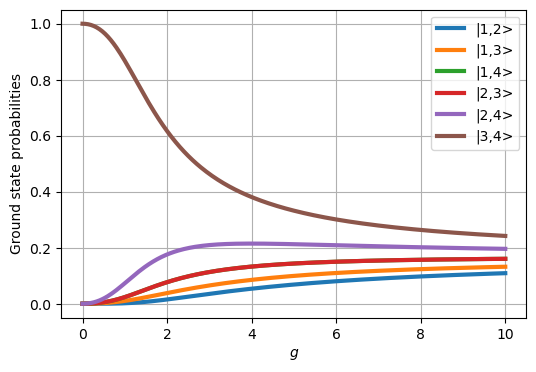

In [9]:
#for a varying pairing strength
g_vals = np.linspace(0.0, 10.0, 301)
prob_g = np.zeros((len(g_vals), len(lol)))
energies = np.zeros((len(g_vals), len(lol)))

for i, g in enumerate(g_vals):
  H_init, lol = H(delta, g, lvl)
  eigen_values, eigen_vectors = np.linalg.eigh(H_init)
  ordered = np.argsort(eigen_values)
  eigen_values = eigen_values[ordered]
  #eigen_vectors  
  new_g = eigen_vectors[:, np.argmin(eigen_values)]
  prob_g[i] = np.abs(new_g)**2
  energies[i] = eigen_values

plt.figure(figsize=(6, 4))
for i, (a, b) in enumerate(lol):
  plt.plot(g_vals, prob_g[:, i], label=f"|{a},{b}>", linewidth=3, linestyle="-")
plt.xlabel("$g$")
plt.ylabel("Ground state probabilities")
plt.legend()
plt.grid(True)
plt.show()



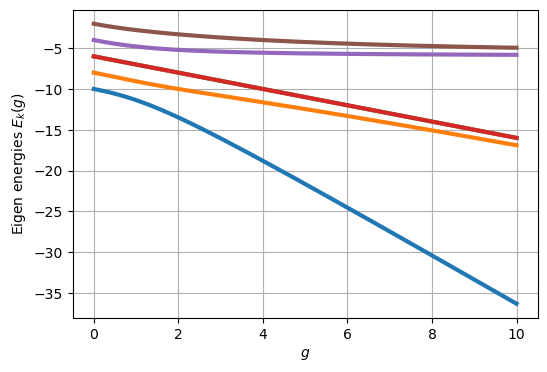

In [10]:
plt.figure(figsize=(6,4))
for k in range(len(lol)):
    plt.plot(g_vals, energies[:, k], linewidth = 3)
plt.xlabel("$g$")
plt.ylabel(r"Eigen energies $E_k(g)$")
#plt.tight_layout()
plt.grid()
#plt.legend()
plt.show()

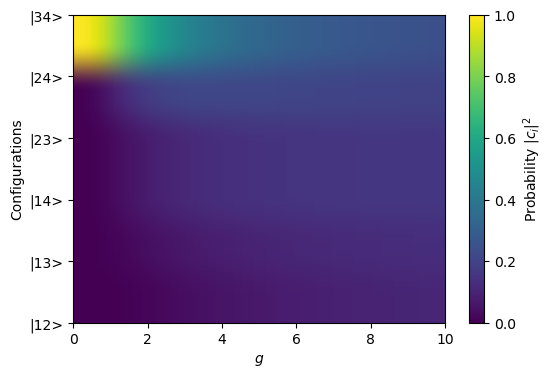

In [11]:
plt.figure(figsize=(6,4))
plt.imshow(prob_g.T, aspect='auto', origin='lower', extent=[g_vals[0], g_vals[-1], 0, len(lol)-1])
plt.yticks(range(len(lol)), [f"|{i}{j}>" for (i,j) in lol])
plt.xlabel("$g$")
plt.ylabel("Configurations")
cbar = plt.colorbar()
cbar.set_label(r"Probability $|c_i|^2$")
plt.show()

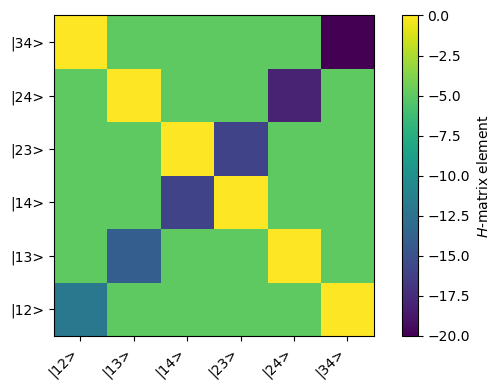

In [12]:
H_init, lol = H(delta, g, lvl)

labels = [f"|{i}{j}>" for (i, j) in lol]

import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.imshow(H_init, origin='lower', aspect='equal')
plt.xticks(range(len(lol)), labels, rotation=45, ha='right')
plt.yticks(range(len(lol)), labels)
plt.colorbar(label="$H$-matrix element")
plt.tight_layout()
plt.show()